In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [28]:
# load the breast_cancer dataset
init_data = load_breast_cancer()
(X, y) = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(data=X, columns=init_data['feature_names'])
y = pd.DataFrame(data=y, columns=['label'])

In [29]:
# Let's try PCA first
from sklearn.preprocessing import StandardScaler
import numpy as np

# Z-Standardlization
sc = StandardScaler()
Z = sc.fit_transform(X)
# Correlation Matrix
R = np.dot(Z.T, Z) / X.shape[0]

# eigenvector and eigenvalue
eigen_vals, eigen_vecs = np.linalg.eigh(R)
print('\nEigenvalues: \n %s\n' % eigen_vals)
#print('\nEigenvecs: \n %s\n' % eigen_vecs)
# List of (eigen_vals, eigen_vecs) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse=True)


Eigenvalues: 
 [  1.33044823e-04   7.48803097e-04   1.58933787e-03   6.90046388e-03
   8.17763986e-03   1.54812714e-02   1.80550070e-02   2.43408378e-02
   2.74394025e-02   2.99728939e-02   3.11594025e-02   4.94775918e-02
   5.26187835e-02   5.93990378e-02   7.98628010e-02   9.41349650e-02
   1.57009724e-01   2.41357496e-01   2.61161370e-01   2.93915696e-01
   3.50693457e-01   4.16894812e-01   4.76617140e-01   6.75220114e-01
   1.20735661e+00   1.64873055e+00   1.98064047e+00   2.81794898e+00
   5.69135461e+00   1.32816077e+01]



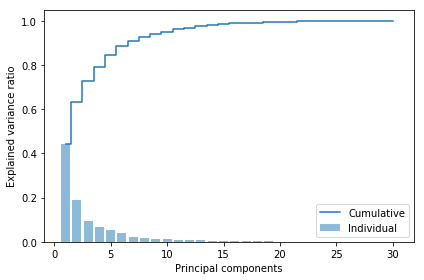

In [30]:
# Visualize
import matplotlib.pyplot as plt

tot = sum(np.abs(eigen_vals))
var_exp = [(i / tot) for i in sorted(np.abs(eigen_vals), reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, eigen_vals.size + 1), var_exp, alpha=0.5, align='center',
        label='Individual')
plt.step(range(1, eigen_vals.size + 1), cum_var_exp, where='mid',
         label='Cumulative')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('./output/fig-pca-var-exp.png', dpi=300)
plt.show()

In [31]:
W_2D = np.hstack((eigen_pairs[0][1][:, np.newaxis],  # np.newaxis：改變matrix形狀
                  eigen_pairs[1][1][:, np.newaxis]))

W_3D = np.hstack((eigen_pairs[0][1][:, np.newaxis],
                  eigen_pairs[1][1][:, np.newaxis],
                  eigen_pairs[2][1][:, np.newaxis]))
#print('Projection matrix W:\n', W_3D)

In [32]:
Z_PCA = Z.dot(W_2D)
print('# of Features：%d' % Z_PCA.shape[1])

# of Features：2


In [33]:
# split Z_PCA into training and testing sets
Z_PCA_train, Z_PCA_test, y_PCA_train, y_PCA_test = train_test_split(Z_PCA, y, test_size=0.3, random_state=0)

# Train a RandomForestClassifier as model 
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=200, 
                                random_state=1,
                                n_jobs=2)
forest.fit(Z_PCA_train, y_PCA_train)

y_pred = forest.predict(Z_PCA_test)
print('PCA_Accuracy: %.2f' % accuracy_score(y_PCA_test, y_pred))
print('PCA_Accuracy per feature: %.2f' % (accuracy_score(y_PCA_test, y_pred)/Z_PCA.shape[1]))

C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


PCA_Accuracy: 0.91
PCA_Accuracy per feature: 0.46


In [34]:
# How about Feature Importance?
# split X into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Train a RandomForestClassifier as model 
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=200, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('Accuracy per feature: %.2f' % (accuracy_score(y_test, y_pred)/len(X.columns)))

C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


Accuracy: 0.98
Accuracy per feature: 0.03


 1) worst concave points           0.141849
 2) mean concave points            0.117697
 3) worst radius                   0.110919
 4) worst perimeter                0.105243
 5) mean concavity                 0.077163
 6) worst area                     0.073364
 7) area error                     0.041760
 8) mean perimeter                 0.036943
 9) mean radius                    0.035625
10) worst concavity                0.035205
11) mean area                      0.032890
12) worst texture                  0.022736
13) mean texture                   0.018584
14) worst compactness              0.016786
15) radius error                   0.015408
16) worst symmetry                 0.014770
17) worst smoothness               0.014235
18) mean compactness               0.010085
19) perimeter error                0.010040
20) worst fractal dimension        0.009015
21) concave points error           0.008085
22) compactness error              0.007420
23) mean smoothness             

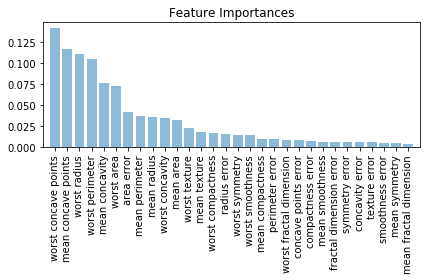

In [35]:
# Computing Feature Importance
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

importances = forest.feature_importances_
# get sort indices in descending order
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            X.columns.values[indices[f]], 
                            importances[indices[f]]))

plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center',
        alpha=0.5)

plt.xticks(range(X_train.shape[1]), 
           X.columns.values[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('./output/fig-forest-feature-importances.png', dpi=300)
plt.show()

In [36]:
# Feature Selection
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.117)
# calls forest.fit()
sfm.fit(X_train, y_train)
Z_forest_alt = sfm.transform(X)

for f in range(Z_forest_alt.shape[1]): #mdf
    print("%2d) %-*s %f" % (f + 1, 30, 
                            X.columns.values[indices[f]], 
                            importances[indices[f]]))

C:\Users\Rohan\Anaconda3\lib\site-packages\sklearn\feature_selection\from_model.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


 1) worst concave points           0.141849
 2) mean concave points            0.117697


In [37]:
Z_forest = X[['worst concave points', 'mean concave points']].values
print('# of Features：%d' % Z_forest.shape[1])

# of Features：2


In [38]:
Z_forest_train, Z_forest_test, y_forest_train, y_forest_test = train_test_split(
    Z_forest, y, test_size=0.3, random_state=0)

# Train a RandomForestClassifier as model 
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=200, 
                                random_state=1,
                                n_jobs=2)
forest.fit(Z_forest_train, y_forest_train)

y_pred = forest.predict(Z_forest_test)
print('Feature_Selection_Accuracy: %.2f' % accuracy_score(y_forest_test, y_pred))
print('Feature_Selection_Accuracy per feature: %.2f' % (accuracy_score(y_forest_test, y_pred)/Z_forest.shape[1]))

C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Feature_Selection_Accuracy: 0.89
Feature_Selection_Accuracy per feature: 0.44
